<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/lstm_%EC%9E%AC%EB%AC%B4%EC%A0%95%EB%B3%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 재무지표를 포함한 lstm 종가 예측

## 라이브러리 설치

In [1]:
# 필요 라이브러리 설치
!pip install finance-datareader
!pip install pykrx

## 패키지 로딩 및 함수 로딩

In [6]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 주식가격 로딩
import FinanceDataReader as fdr
from pykrx import stock

import datetime

In [7]:
def money_sur(stock_name, start, end):

  # 라이브러리를 찾음... 한방에 나옴...
    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')

    return data

## 데이터 로드

In [8]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
df = money_sur('005930',2018, end_date)

In [9]:
df

,Date,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
0,2018-01-02,51380,51400,50780,51020,169485,0.001177,1156530,16.15,2.21,157967,1.12,28500
1,2018-01-03,52540,52560,51420,51620,200270,0.011760,1156530,16.34,2.23,157967,1.10,28500
2,2018-01-04,52120,52180,50640,51080,233909,-0.010461,1156530,16.17,2.21,157967,1.12,28500
3,2018-01-05,51300,52120,51200,52120,189623,0.020360,1156530,16.50,2.25,157967,1.09,28500
4,2018-01-08,52400,52520,51500,52020,167673,-0.001919,1156530,16.47,2.25,157967,1.10,28500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,2021-09-10,75300,75600,74800,75300,10103212,0.000000,39406,19.60,1.91,3841,3.98,2994
912,2021-09-13,75200,76300,75100,76300,11397775,0.013280,39406,19.86,1.94,3841,3.92,2994
913,2021-09-14,77100,77700,76600,76600,18167057,0.003932,39406,19.94,1.94,3841,3.91,2994
914,2021-09-15,77400,77400,76400,77000,12829128,0.005222,39406,20.05,1.95,3841,3.89,2994


## 데이터 전처리

In [10]:
df1 = df.set_index('Date')

In [11]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'BPS', 'PER', 'PBR',
       'EPS', 'DIV', 'DPS'],
      dtype='object')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


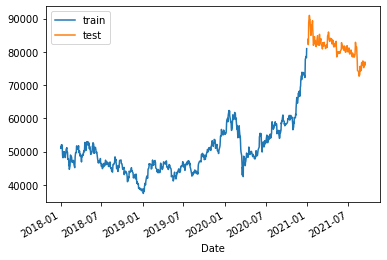

In [12]:
# test --> 21년 이후 , train --> 18~20
split_date = pd.Timestamp('01-01-2021')

train = df1.loc[:split_date, ]
test = df1.loc[split_date:, ]

ax = train['Close'].plot()
test['Close'].plot(ax=ax)
plt.legend(['train', 'test'])

In [13]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc

array([[0.65037975, 0.63222632, 0.64936061, ..., 0.52173898, 0.01694914,
        0.66386555],
       [0.66506329, 0.64649446, 0.65754476, ..., 0.52173898, 0.00847457,
        0.66386555],
       [0.65974684, 0.64182042, 0.64757033, ..., 0.52173898, 0.01694914,
        0.66386555],
       ...,
       [1.        , 0.98523985, 1.        , ..., 0.        , 0.30508471,
        0.01358944],
       [0.99746835, 0.9704797 , 0.98849105, ..., 0.        , 0.30932199,
        0.01358944],
       [0.97974684, 1.        , 0.98849105, ..., 0.        , 0.28389829,
        0.01358944]])

In [17]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'BPS', 'PER', 'PBR',
       'EPS', 'DIV', 'DPS'],
      dtype='object')

In [59]:
scale_cols = list(df1.columns)

train_sc_df = pd.DataFrame(train_sc, columns=[scale_cols], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=[scale_cols], index=test.index)

In [31]:
# 종가로만 예측 시
# train_close = pd.DataFrame(train_sc_df[('Close',)])
# test_close = pd.DataFrame(test_sc_df[('Close',)])

In [60]:
for i in scale_cols:
  for s in range(1, 13):  
    train_sc_df[(i+'shift_{}'.format(s),)] = train_sc_df[(i,)].shift(s)
    test_sc_df[(i+'shift_{}'.format(s),)] = test_sc_df[(i,)].shift(s)

train_sc_df.head(13)
train_sc_df.shape

(738, 156)

In [105]:
train_sc_df.columns

MultiIndex([(       'Open',),
            (       'High',),
            (        'Low',),
            (      'Close',),
            (     'Volume',),
            (     'Change',),
            (        'BPS',),
            (        'PER',),
            (        'PBR',),
            (        'EPS',),
            ...
            ( 'DPSshift_3',),
            ( 'DPSshift_4',),
            ( 'DPSshift_5',),
            ( 'DPSshift_6',),
            ( 'DPSshift_7',),
            ( 'DPSshift_8',),
            ( 'DPSshift_9',),
            ('DPSshift_10',),
            ('DPSshift_11',),
            ('DPSshift_12',)],
           length=156)

In [61]:
train_sc_df.head(13)

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Openshift_11,Openshift_12,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Highshift_11,Highshift_12,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,...,PBRshift_9,PBRshift_10,PBRshift_11,PBRshift_12,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,EPSshift_11,EPSshift_12,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DIVshift_11,DIVshift_12,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10,DPSshift_11,DPSshift_12
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.650380,0.632226,0.649361,0.311596,0.002669,0.385888,0.818782,0.512410,0.928571,0.521739,0.016949,0.663866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.665063,0.646494,0.657545,0.325373,0.003154,0.448663,0.818782,0.522234,0.946429,0.521739,0.008475,0.663866,0.650380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.632226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.649361,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.521739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.663866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.659747,0.641820,0.647570,0.312974,0.003684,0.316851,0.818782,0.513444,0.928571,0.521739,0.016949,0.663866,0.665063,0.650380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.646494,0.632226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.657545,0.649361,NaN,NaN,...,NaN,NaN,NaN,NaN,0.521739,0.521739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008475,0.016949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.663866,0.663866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,0.649367,0.641082,0.654731,0.336854,0.002987,0.499677,0.818782,0.530507,0.964286,0.521739,0.004237,0.663866,0.659747,0.665063,0.650380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.641820,0.646494,0.632226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.647570,0.657545,0.649361,NaN,...,NaN,NaN,NaN,NaN,0.521739,0.521739,0.521739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016949,0.008475,0.016949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.663866,0.663866,0.663866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,0.663291,0.646002,0.658568,0.334558,0.002641,0.367523,0.818782,0.528956,0.964286,0.521739,0.008475,0.663866,0.649367,0.659747,0.665063,0.650380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.641082,0.641820,0.646494,0.632226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.654731,0.647570,0.657545,0.649361,...,NaN,NaN,NaN,NaN,0.521739,0.521739,0.521739,0.521739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004237,0.016949,0.008475,0.016949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.663866,0.663866,0.663866,0.663866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,0.651392,0.636162,0.639130,0.297359,0.005674,0.194177,0.818782,0.502068,0.901786,0.521739,0.021186,0.663866,0.663291,0.649367,0.659747,0.665063,0.650380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.646002,0.641082,0.641820,0.646494,0.632226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.658568,0.654731,0.647570,0.657545,...,NaN,NaN,NaN,NaN,0.521739,0.521739,0.521739,0.521739,0.521739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008475,0.004237,0.016949,0.008475,0.016949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.663866,0.663866,0.663866,0.663866,0.663866,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,0.639241,0.621402,0.621995,0.261538,0.005849,0.195301,0.818782,0.476732,0.839286,0.521739,0.038136,0.663866,0.651392,0.663291,0.649367,0.659747,0.665063,0.650380,NaN,NaN,NaN,NaN,NaN,NaN,0.636162,0.646002,0.641082,0.641820,0.646494,0.63

In [71]:
X_train = train_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_train = train_sc_df.dropna()[['Close']]

X_test = test_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_test = test_sc_df.dropna()[['Close']]

X_train.head()

,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Openshift_11,Openshift_12,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Highshift_11,Highshift_12,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,Lowshift_9,Lowshift_10,Lowshift_11,Lowshift_12,Closeshift_1,Closeshift_2,Closeshift_3,Closeshift_4,...,PBRshift_9,PBRshift_10,PBRshift_11,PBRshift_12,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,EPSshift_11,EPSshift_12,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DIVshift_11,DIVshift_12,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10,DPSshift_11,DPSshift_12
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-18,0.633165,0.617215,0.617722,0.610633,0.610127,0.639241,0.651392,0.663291,0.649367,0.659747,0.665063,0.650380,0.615252,0.616728,0.602460,0.596310,0.605904,0.621402,0.636162,0.646002,0.641082,0.641820,0.646494,0.632226,0.627366,0.621739,0.612788,0.597954,0.614066,0.621995,0.639130,0.658568,0.654731,0.647570,0.657545,0.649361,0.279449,0.288175,0.254650,0.246843,...,0.964286,0.928571,0.946429,0.928571,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.029661,0.025424,0.038136,0.042373,0.042373,0.038136,0.021186,0.008475,0.004237,0.016949,0.008475,0.016949,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866
2018-01-19,0.633165,0.633165,0.617215,0.617722,0.610633,0.610127,0.639241,0.651392,0.663291,0.649367,0.659747,0.665063,0.622878,0.615252,0.616728,0.602460,0.596310,0.605904,0.621402,0.636162,0.646002,0.641082,0.641820,0.646494,0.637084,0.627366,0.621739,0.612788,0.597954,0.614066,0.621995,0.639130,0.658568,0.654731,0.647570,0.657545,0.285878,0.279449,0.288175,0.254650,...,0.964286,0.964286,0.928571,0.946429,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.025424,0.029661,0.025424,0.038136,0.042373,0.042373,0.038136,0.021186,0.008475,0.004237,0.016949,0.008475,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866
2018-01-22,0.637722,0.633165,0.633165,0.617215,0.617722,0.610633,0.610127,0.639241,0.651392,0.663291,0.649367,0.659747,0.619680,0.622878,0.615252,0.616728,0.602460,0.596310,0.605904,0.621402,0.636162,0.646002,0.641082,0.641820,0.627110,0.637084,0.627366,0.621739,0.612788,0.597954,0.614066,0.621995,0.639130,0.658568,0.654731,0.647570,0.272560,0.285878,0.279449,0.288175,...,0.901786,0.964286,0.964286,0.928571,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.033898,0.025424,0.029661,0.025424,0.038136,0.042373,0.042373,0.038136,0.021186,0.008475,0.004237,0.016949,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866
2018-01-23,0.615696,0.637722,0.633165,0.633165,0.617215,0.617722,0.610633,0.610127,0.639241,0.651392,0.663291,0.649367,0.598770,0.619680,0.622878,0.615252,0.616728,0.602460,0.596310,0.605904,0.621402,0.636162,0.646002,0.641082,0.613299,0.627110,0.637084,0.627366,0.621739,0.612788,0.597954,0.614066,0.621995,0.639130,0.658568,0.654731,0.247761,0.272560,0.285878,0.279449,...,0.839286,0.901786,0.964286,0.964286,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.521739,0.042373,0.033898,0.025424,0.029661,0.025424,0.038136,0.042373,0.042373,0.038136,0.021186,0.008475,0.004237,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866,0.663866
2018-01-24,0.615949,0.615696,0.63772

In [73]:
print(type(X_train))
X_train = X_train.values
print(type(X_train))
X_test= X_test.values
y_train = y_train.values
y_test = y_test.values
 

print(X_train.shape)
print(y_train.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(726, 144)
(726, 1)


In [77]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 12)
X_test_t = X_test.reshape(X_test.shape[0], 12, 12)

## LSTM 실행

### tensor 사용해서 window 만들기

In [12]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE=20
BATCH_SIZE=32

In [13]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [14]:
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, feature갯수): (32, 1)


### 모델

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(LSTM(64,
               input_shape = (12, 12),
               return_sequences= True))
model.add(LSTM(64,
               return_sequences = False))
model.add(Dense(32, activation = 'tanh'))
model.add(Dense(1))

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 64)            19712     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 54,849
Trainable params: 54,849
Non-trainable params: 0
_________________________________________________________________


In [83]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# earlystopping은 30번 epoch통안 val_loss 개선이 없다면 학습 중지
earlystopping = EarlyStopping(monitor='val_loss', patience=30)
# val_loss 기준 체크포인터도 생성
filename = 'lstm_samsung.h5'
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [86]:
history = model.fit(X_train_t, y_train, validation_data=(X_test_t,y_test),
                    epochs=300, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/300
23/23 [==============================] - 1s 54ms/step - loss: 2.8740e-04 - mse: 5.7479e-04 - val_loss: 4.7569e-04 - val_mse: 9.5138e-04

Epoch 00001: val_loss improved from inf to 0.00048, saving model to lstm_samsung.h5
Epoch 2/300
23/23 [==============================] - 0s 12ms/step - loss: 2.9938e-04 - mse: 5.9875e-04 - val_loss: 0.0017 - val_mse: 0.0033

Epoch 00002: val_loss did not improve from 0.00048
Epoch 3/300
23/23 [==============================] - 0s 12ms/step - loss: 3.7469e-04 - mse: 7.4937e-04 - val_loss: 4.8968e-04 - val_mse: 9.7935e-04

Epoch 00003: val_loss did not improve from 0.00048
Epoch 4/300
23/23 [==============================] - 0s 12ms/step - loss: 2.8825e-04 - mse: 5.7651e-04 - val_loss: 4.7949e-04 - val_mse: 9.5897e-04

Epoch 00004: val_loss did not improve from 0.00048
Epoch 5/300
23/23 [==============================] - 0s 12ms/step - loss: 2.9325e-04 - mse: 5.8650e-04 - val_loss: 6.7113e-04 - val_mse: 0.0013

Epoch 00005: val_loss did not 

In [87]:
model.load_weights(filename)
pred = model.predict(X_test_t)

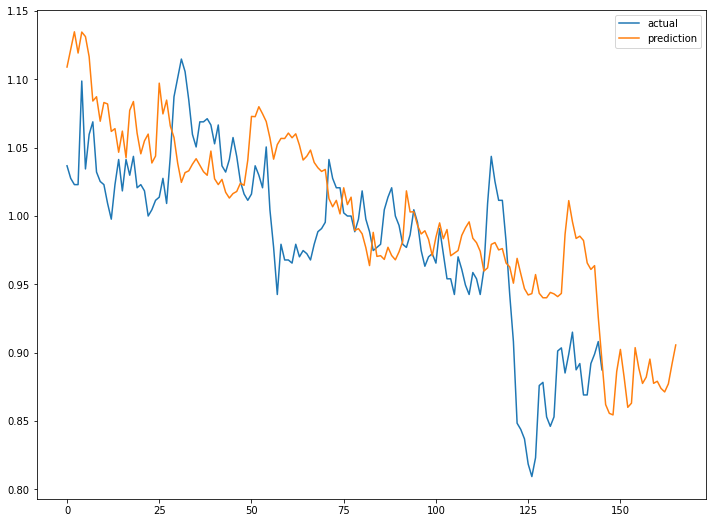

In [88]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [90]:
score = model.evaluate(X_test_t,y_test,batch_size=30)
print(score)

6/6 [==============================] - 0s 5ms/step - loss: 4.4744e-04 - mse: 8.9489e-04
[0.00044744269689545035, 0.0008948853937909007]


In [94]:
test_sc_df[('Close',)].describe()

count    178.000000
mean       1.006734
std        0.077484
min        0.809414
25%        0.970149
50%        1.012629
75%        1.043628
max        1.229621
Name: (Close,), dtype: float64

Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

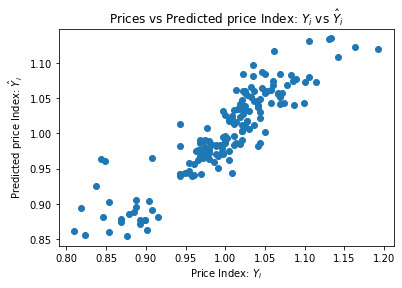

In [107]:
# 직선에 가까울 수록 정확도가 높다
y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")